In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import technical_analysis.backtest_kz as bt
from data_pipelines.data_manipulation import DataManipulation
import warnings
import numpy as np
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

In [3]:
SYMBOL = 'BTC-USD'
scale = 1
range = [5, 10, 15, 20, 25, 30, 50, 99]
range = [i*scale for i in range]
period = '2y'
interval = '1d'
start_date = ''
end_data = ''
source = 'yahoo'

In [4]:
data = DataManipulation(SYMBOL, source, range, period=period, interval=interval, scale=scale, prefix_path='..')

[*********************100%***********************]  1 of 1 completed


In [5]:
data.df.tail()

,Open,High,Low,Close,Volume,sma_5,sma_10,sma_15,sma_20,sma_25,...,stoch_d,ich_kline,ich_tline,FISHERT_9_1,FISHERTs_9_1,log_rt,candlestick_pattern,candle_label,d_r,feature_label
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-11-05,21144.8320,21446.8867,21097.6348,21282.6914,37846047609,20656.9375,20611.5729,20340.1865,20067.6857,19896.6180,...,71.0659,19883.3545,20766.4775,0.9510,0.7621,0.0064,NO_PATTERN,0.0000,0.0064,1.0000
2022-11-06,21285.0566,21345.3770,20920.1914,20926.4863,35082693210,20745.1801,20675.6379,20454.7396,20136.4722,19967.3796,...,66.6667,19883.3545,20766.5635,1.1479,0.9510,-0.0169,CDLCLOSINGMARUBOZU_Bear,-1.0000,-0.0167,1.0000
2022-11-07,20924.6211,21053.2461,20489.9727,20602.8164,53510852236,20833.8426,20676.3844,20523.7935,20199.8922,20016.1761,...,33.3333,19883.3545,20766.5635,1.0032,1.1479,-0.0156,CDL3OUTSIDE_Bear,-1.0000,-0.0155,0.0000
2022-11-08,20600.6719,20664.6074,17603.5449,18541.2715,118992465607,20500.0992,20448.6639,20470.1734,20169.9790,19990.4007,...,0.0000,19525.2158,19525.2158,0.4427,1.0032,-0.1054,NO_PATTERN,0.0000,-0.1001,0.0000
2022-11-09,18509.1562,18590.4590,17648.8535,17648.8535,114660024320,19800.4238,20149.9889,20307.0398,20099.7347,19933.6495,...,0.0000,19525.2158,19525.2158,-0.1664,0.4427,-0.0493,CDLCLOSINGMARUBOZU_Bear,-1.0000,-0.0481,0.0000


In [6]:
df = data.df
sample  = df[['Open','High','Low','Close','Volume']].copy()
sample.drop(columns=['Open','High','Low'], axis=1, inplace=True)
sample['st_hisse'] = np.nan
sample['st_stoch'] = np.nan
sample['st_fisher'] = np.nan
sample['st_ich'] = np.nan
sample['st_mfi'] = np.nan

In [7]:
for index, datetime in enumerate(df.index):
        current_datetime = datetime
        ema5 = df['ema_5'].iloc[index]
        sma10 = df['sma_10'].iloc[index]
        macd = df['macd'].iloc[index]
        macds = df['macdsignal'].iloc[index]
        ichkline = df['ich_kline'].iloc[index]
        ichtline = df['ich_tline'].iloc[index]
        close = df['Close'].iloc[index]
        dmu = df['dmi_up_15'].iloc[index]
        dmd = df['dmi_down_15'].iloc[index]
        stk = df['stoch_k'].iloc[index]
        std = df['stoch_d'].iloc[index]
        fischer = df['FISHERT_9_1'].iloc[index]
        mfi = df['mfi_20'].iloc[index]

        if stk >= std:
                sample['st_stoch'].iloc[index] = 1
        else:
                sample['st_stoch'].iloc[index] = 0

        if fischer >= 2.5:
                sample['st_fisher'].iloc[index] = 3
        elif fischer >= -2.5:
                sample['st_fisher'].iloc[index] = 2
        else:
                sample['st_fisher'].iloc[index] = 1 

        if mfi >= 75:
                sample['st_mfi'].iloc[index] = 3
        elif mfi >= 25:
                sample['st_mfi'].iloc[index] = 2
        else:
                sample['st_mfi'].iloc[index] = 1 

        pattern1 = ema5 >= sma10
        pattern2 = macd > macds
        pattern3 = ichkline < close
        pattern4 = dmu >= dmd
        pattern5 = sma10 < close
        pattern6 = stk > std

        all_pattern = (pattern1 and pattern2 and pattern3 and pattern4 and pattern5 and pattern6)
        if all_pattern:
                sample['st_hisse'].iloc[index] = 1
        else:
                sample['st_hisse'].iloc[index] = 0

In [8]:
def norm_features_ind(sdf, df2, ind, range, dividend):
    k = 0
    for i in range:
        sdf[f'st_{ind}_{i}'] = (dividend - df2[f'{ind}_{i}']) / dividend
        if k % 2 == 1:
            sdf[f'st_cut_{ind}_{range[k-1]}_{range[k]}'] = \
                    (df2[f'{ind}_{range[k-1]}'] > df2[f'{ind}_{range[k]}']).astype(int)
        k += 1


In [9]:
def norm_adx_ind(sdf, df2, range):
    for i in range:
        sdf[f'st_adx_{i}'] = (100 - df2[f'adx_{i}']) / 100
        pattern1 = df2[f'adx_{i}'] < 50
        pattern2 = df2[f'dmi_up_{i}'] > df2[f'dmi_down_{i}']
        sdf[f'st_adxdmi_{i}'] = (pattern2).astype(int) + pattern1
            

In [10]:
norm_features_ind(sample, df, 'ema', range, df.Close)
norm_features_ind(sample, df, 'mfi', range, 100)
norm_features_ind(sample, df, 'sma', range, df.Close)
norm_features_ind(sample, df, 'wma', range, df.Close)
norm_features_ind(sample, df, 'tema', range, df.Close)
norm_features_ind(sample, df, 'kama', range, df.Close)
norm_features_ind(sample, df, 'rsi', range, 100)
norm_adx_ind(sample, df, range)
sample['st_ich'] = (df['ich_tline'] > df['ich_kline']).astype(int)

In [11]:
def add_lags(sdf: pd.DataFrame(), df2: pd.DataFrame(), lag_numbers: int) -> None:
    i = 1
    while i < lag_numbers:
        sdf[f'lag_{i}'] = (df2.log_rt.shift(i) > 0).astype(int)
        i += 1

In [12]:
sample['month'] = sample.index.month
sample['weekday'] = sample.index.weekday
sample['is_quarter_end'] = sample.index.is_quarter_end*1
sample['candle'] = df.candle_label
sample['vol_delta'] = sample['Volume'].pct_change()
add_lags(sample, df, 5)
sample['log_return'] = df.log_rt
sample.drop(columns=['Close', 'Volume'], axis=1, inplace=True)

<AxesSubplot:xlabel='Datetime'>

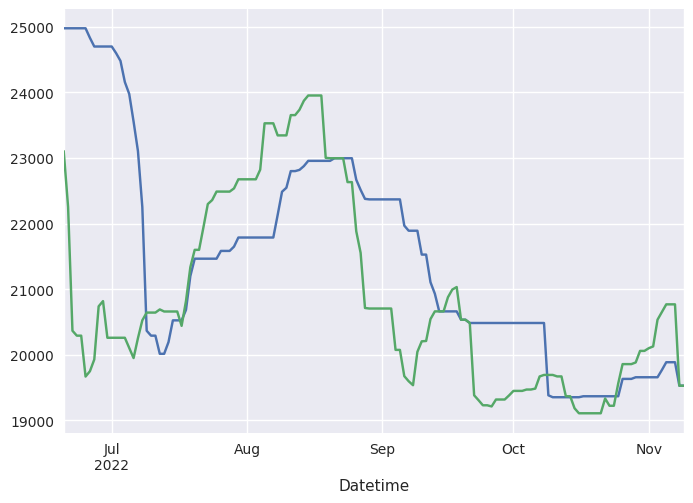

In [13]:
df.ich_kline.plot()
df.ich_tline.plot()

In [14]:
sample.head()

,st_hisse,st_stoch,st_fisher,st_ich,st_mfi,st_ema_5,st_ema_10,st_cut_ema_5_10,st_ema_15,st_ema_20,...,month,weekday,is_quarter_end,candle,vol_delta,lag_1,lag_2,lag_3,lag_4,log_return
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-06-20,0.0000,1.0000,1.0000,0,1.0000,-0.0101,-0.0878,0,-0.1556,-0.2084,...,6,0,0,1.0000,NaN,0,0,0,0,0.0022
2022-06-21,0.0000,0.0000,1.0000,0,1.0000,-0.0031,-0.0671,0,-0.1307,-0.1827,...,6,1,0,1.0000,-0.0600,1,0,0,0,0.0054
2022-06-22,0.0000,0.0000,2.0000,0,1.0000,-0.0263,-0.0865,0,-0.1502,-0.2040,...,6,2,0,-1.0000,-0.0136,1,1,0,0,-0.0356
2022-06-23,0.0000,1.0000,2.0000,0,1.0000,0.0181,-0.0244,0,-0.0790,-0.1278,...,6,3,0,1.0000,-0.0835,0,1,1,0,0.0535
2022-06-24,0.0000,1.0000,2.0000,0,2.0000,0.0166,-0.0142,0,-0.0626,-0.1087,...,6,4,0,1.0000,-0.0470,1,0,1,1,0.0069
